# Notebook for noteDetection
---

## Defining virtual environment

In [1]:
!python -m venv codingweeks

## Part 1: Trying out Fourier Transform (FT)

In [2]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import numpy as np

In [3]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

plt.style.use('ggplot')

In [4]:
filePath = 'data/noteDetection/do0.wav'
rate, data = wav.read(filePath)

In [5]:
np.shape(data)[0]

197568

In [6]:
rate

44100

In [7]:
# sampling information
Fs = rate # sample rate
T = 1/Fs # sampling period
t = np.shape(data)[0] / rate # seconds of sampling
N = Fs*t # total points in signal

t_vec = np.linspace(0,t,N) # time vector for plotting

In [8]:
t

4.48

In [9]:
t_vec

array([0.00000000e+00, 2.26758517e-05, 4.53517035e-05, ...,
       4.47995465e+00, 4.47997732e+00, 4.48000000e+00])

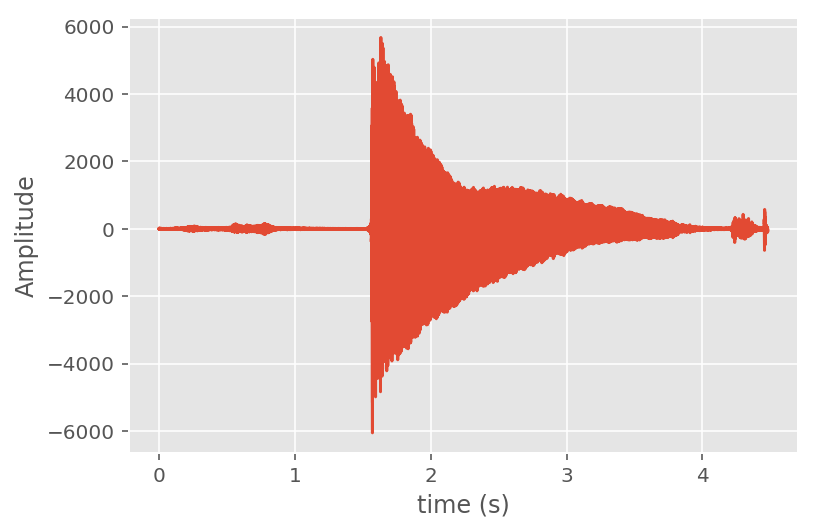

In [10]:
plt.xlabel('time (s)')
plt.ylabel('Amplitude')
plt.plot(t_vec,data[:,1])

plt.show()

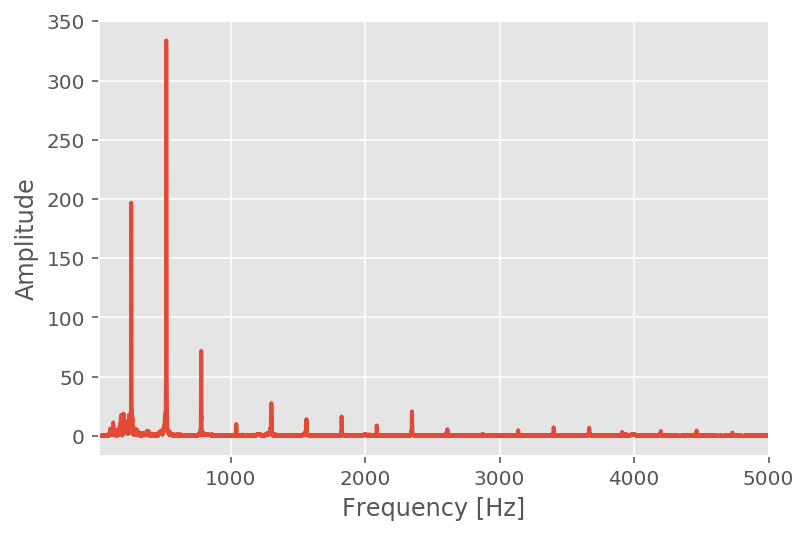

In [11]:
# fourier transform and frequency domain
Y_k = np.fft.fft(data[:,1])[0:int(N/2)]/N # FFT function from numpy
Y_k[1:] = 2*Y_k[1:] # need to take the single-sided spectrum only
Pxx = np.abs(Y_k) # be sure to get rid of imaginary part
f = (1/N) * Fs * np.arange((int(N/2))); # frequency vector

# plotting
plt.ylabel('Amplitude')
plt.xlabel('Frequency [Hz]')
plt.xlim((20,5000)) #to change if needed

plt.plot(f,Pxx,linewidth=2)

plt.show()

In [12]:
def plotTimeSignal(filePath):
    # Get data
    rate, data = wav.read(filePath)
    
    # Get sampling information
    Fs = rate # sample rate
    T = 1/Fs # sampling period
    t = np.shape(data)[0] / rate # seconds of sampling
    N = Fs*t # total points in signal

    t_vec = np.linspace(0,t,N) # time vector for plotting
    
    plt.xlabel('time (s)')
    plt.ylabel('Amplitude')
    plt.plot(t_vec,data[:,1])
    
    return

In [13]:
def plotFT(filePath):
    # Get data
    rate, data = wav.read(filePath)
    
    # Get sampling information
    Fs = rate # sample rate
    T = 1/Fs # sampling period
    t = np.shape(data)[0] / rate # seconds of sampling
    N = Fs*t # total points in signal
    
    # fourier transform and frequency domain
    Y_k = np.fft.fft(data[:,1])[0:int(N/2)]/N # FFT function from numpy
    Y_k[1:] = 2*Y_k[1:] # need to take the single-sided spectrum only
    Pxx = np.abs(Y_k) # be sure to get rid of imaginary part
    f = (1/N) * Fs * np.arange((int(N/2))); # frequency vector

    # plotting
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency [Hz]')
    plt.xlim((20,5000)) #to change if needed
    
    plt.plot(f,Pxx,linewidth=2)
    
    return

In [14]:
def plotTimeAndFT(filePath):
    plt.figure()
    
    plt.subplot(211)
    plotTimeSignal(filePath)
    
    plt.subplot(212)
    plotFT(filePath)
    
    plt.show()
    return

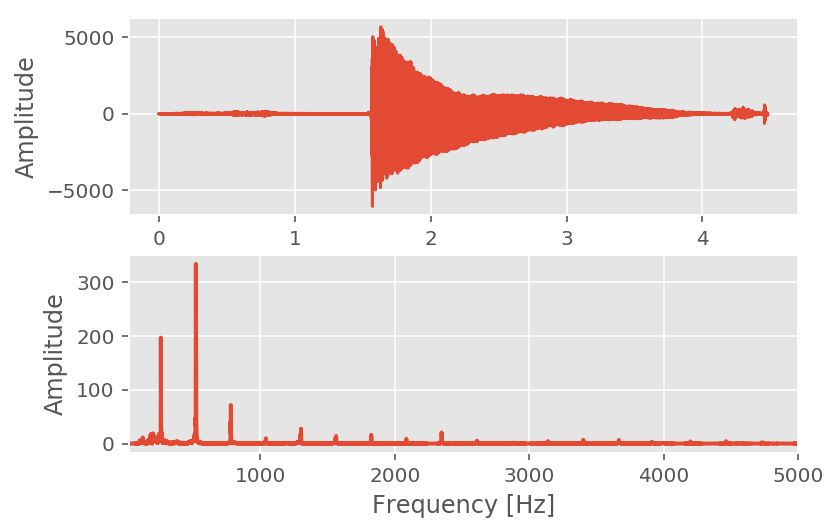

In [15]:
plotTimeAndFT(filePath)

In [16]:
def getFundamentalFreq(filePath):
    # Get data
    rate, data = wav.read(filePath)
    
    # Get sampling information
    Fs = rate # sample rate
    T = 1/Fs # sampling period
    t = np.shape(data)[0] / rate # seconds of sampling
    N = Fs*t # total points in signal
    
    # Process data
    Y_k = np.fft.fft(data[:,1])[0:int(N/2)]/N # FFT function from numpy
    Pxx = np.abs(Y_k) # be sure to get rid of imaginary part
    
    Y_k = np.fft.fft(data[:,1])[0:int(N/2)]/N # FFT function from numpy
    Y_k[1:] = 2*Y_k[1:] # need to take the single-sided spectrum only
    Pxx = np.abs(Y_k) # be sure to get rid of imaginary part
    f = (1/N) * Fs * np.arange((int(N/2))); # frequency vector
    
    return f[Pxx.argmax()]

In [17]:
getFundamentalFreq(filePath)

520.7589285714284

---
## Part 2: Trying to be more precise by using trimmed samples

*What if we start the FT only after the note "attack"?*

In [18]:
filePath_trimmed = 'data/noteDetection/do0_trimmed.wav'

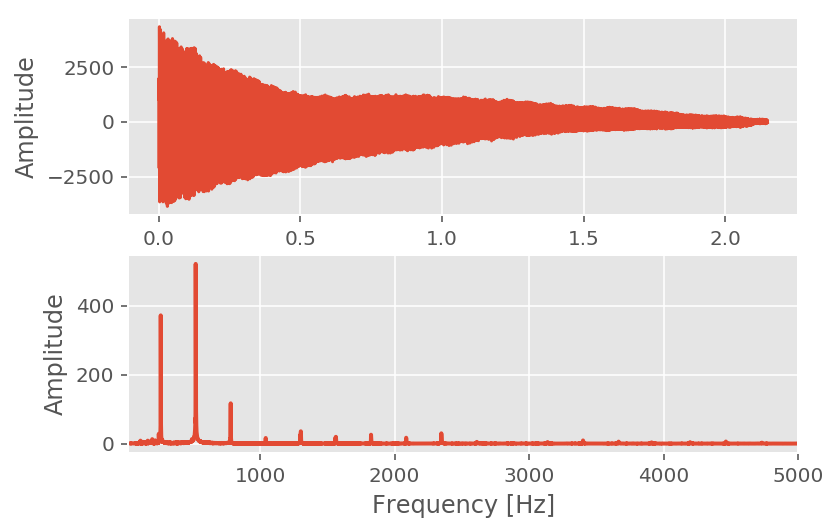

In [19]:
plotTimeAndFT(filePath_trimmed)

In [20]:
getFundamentalFreq(filePath_trimmed)

520.4376713773465

*The two spectograms appear to be very similar.*
**However**, *it might be useful to be able to detect if two different notes have been played for posible implementation of a multiple-notes quizz.*

## ~~Part 3: Decomposing sample into several shorter audio segments each of duration 0.25~~ ##
## REVOKED ##

In [21]:
from pydub import AudioSegment
from pydub.playback import play
import IPython
import os

In [22]:
IPython.display.Audio('data/noteDetection/do0.wav')

In [23]:
def getListTrimmed(fileName, smallClipDuration, save = 0):
    '''save = 1 -> save the trimmed files
    NB: fileName only contains the file name inside of data/noteDetection/'''
    
    path = 'data/noteDetection/' + fileName
    audio = AudioSegment.from_file(path, format="wav")
    duration_ms = len(audio)
    
    lAudio = []
    
    i= 0
    while i+smallClipDuration < duration_ms:
        lAudio.append(audio[i:i+smallClipDuration])
        i+=smallClipDuration
    
    lAudio.append(audio[i:])
    
    # Get saving location
    cwd = os.getcwd()
    os.chdir(cwd + '/data/noteDetection/trimmed')
    
    # Saving the file if asked
    if save == 1:
        for idx, audio in enumerate(lAudio):
            audio.export(fileName[:-4] + 'trimmed_' + str(idx + 1) + '.wav', format='wav')
            #fileName[:-4] allow to get rid of the redundant '.wav'
    
    #Going back to the root of the project directory
    os.chdir(cwd)
    return lAudio

## Part 3bis: Silence detector

### We'll arbitrarily define a * silent part * as an audio segment where max(abs(amplitude)) <= 1000. ###

### 3.1: we need to find a way to extract the envelope of a signal. Let's try using a low-pass filter.

In [28]:
from scipy import signal

In [29]:
filePath = 'data/noteDetection/doremi.wav'
# Get data
rate, data = wav.read(filePath)

# sampling information
Fs = rate # sample rate
T = 1/Fs # sampling period
t = np.shape(data)[0] / rate # seconds of sampling
N = int(Fs*t) # total points in signal

YY = data[:,1]

In [30]:
margin = int(N / 100)

In [31]:
margin

3798

In [32]:
N

379840

In [33]:
t_vec[margin:N-margin]

array([0.08612288, 0.08614556, 0.08616824, ..., 4.47995465, 4.47997732,
       4.48      ])

/Users/Tony/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


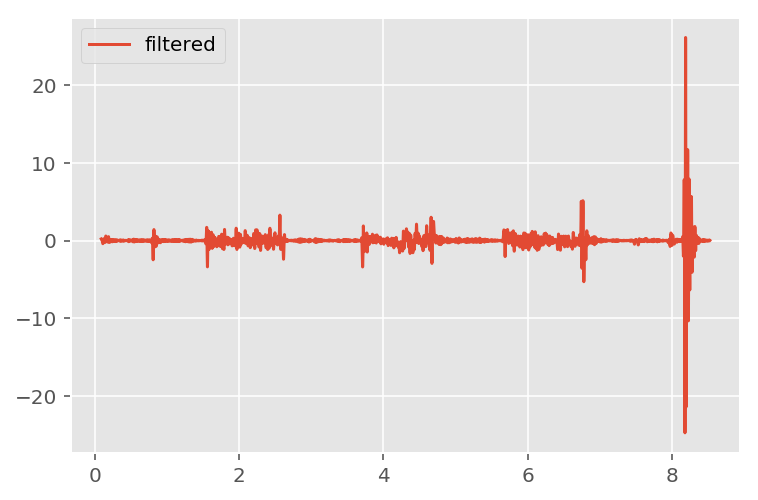

In [34]:
fs = rate
t = np.shape(data)[0] / rate # seconds of sampling
t_vec = np.linspace(0,t,N) # time vector for plotting
fc = 50  # Cut-off frequency of the filter, which corresponds to a C2
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(4, w, 'low')
output = signal.filtfilt(b, a, YY)
plt.plot(t_vec[margin:-1 * margin], output[margin:-1 *margin], label='filtered')
plt.legend()
plt.show()

### 3.2 Trying scipy's peak function

In [35]:
from scipy.signal import find_peaks

In [96]:
N / 100

3798.4

In [97]:
def plotEnvelope(t_vec, YY, N, show = 0):
    peaks, _ = find_peaks(YY, distance= (N / 100))
    plt.xlabel('time (s)')
    plt.ylabel('Amplitude')
    plt.plot(t_vec,YY)
    t_vec_peaks = t_vec[peaks] # syntax to only retrieve the chosen indexes
    plt.plot(t_vec_peaks, YY[peaks], "--", label='envelope')
    plt.legend()
    plt.savefig('envelope.png', dpi=150)
    if show == 1:
        plt.show()
    return

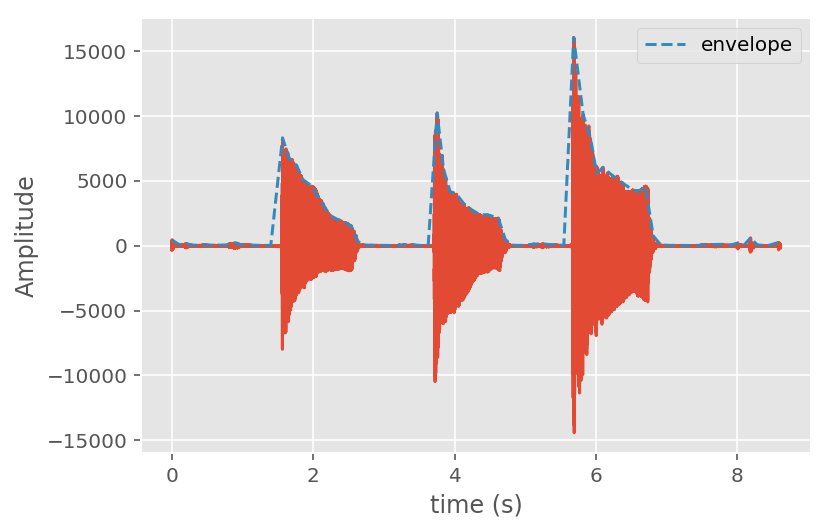

In [98]:
plotEnvelope(t_vec, YY, N, show = 0)

In [38]:
def getIdxEnvelope(YY_amplitude, N):
    ''' returns the INDEX of YY_amplitude considered as peaks'''
    idx_peaks, _ = find_peaks(YY_amplitude, distance= (N / 100)) # The 100 has been empiricaly chosen.
    return idx_peaks

In [94]:
def getSilenceTimestamps(data, rate, show = 0):
    '''From data and rate (extracted from wav.read), returns lSilenceTimestamps which is a list of 2-elts tuples such as (silenceStart, silenceEnd).'''
    
    YY_amplitude = data[:,1] # contains the list of amplitudes taken in each 
    
    # Get sampling information
    Fs = rate # sample rate
    T = 1/Fs # sampling period
    t = np.shape(data)[0] / rate # seconds of sampling
    N = int(Fs*t) # total points in signal
    

    t_vec = np.linspace(0,t,N) # time vector for plotting
    
    # Silent parts related
    silentThreshold = 1000 # can be changed if needed
    silentEndThreshold = 1500 # allows to prevent to detect too many silent parts
    lSilenceTimestamps = []
    
    # Now let's get the envelope
    idx_peaks = getIdxEnvelope(YY_amplitude, N)
    t_vec_peaks = t_vec[idx_peaks]
    YY_peaks = YY_amplitude[idx_peaks]
    
    # ------------------------------------------------------------------------------------------------------------
    
    # Strategy: Let's browse through the amplitude array and each time we get below silentThreshold,
    # it means that a new "silent part" is starting.
    
    hasSilentBegun = False
    
    for idx, amplitude in np.ndenumerate(YY_peaks):
        if not(hasSilentBegun): # if we still haven't detected a new silent part...
            if abs(amplitude) <= silentThreshold:
                hasSilentBegun = True
                timeStart = t_vec_peaks[idx[0]] #idx is a 1D tuple
        else: # ie "if hasSilentBegun"
            if abs(amplitude) > silentEndThreshold: 
                hasSilentBegun = False
                timeEnd = t_vec_peaks[idx[0]]
                
                # We can now add the timestamps in lSilenceTimestamps
                lSilenceTimestamps.append((timeStart,timeEnd))
    
    # if when we've finished browsing YY_amplitude, a silent part has begun but not ended, we'll add it manually.
    hasSilentBegun = False
    timeEnd = t_vec[-1]
    lSilenceTimestamps.append((timeStart,timeEnd))
    
    # Amplitude wrt to time
    plt.xlabel('time (s)')
    plt.ylabel('Amplitude')
    plt.plot(t_vec_peaks, YY_peaks, 'b', label='signal')
    
    # Let's plot the horizontal lines that allow to define silent parts.
    
    n = np.shape(t_vec_peaks)[0]
    YY_silentThreshold = [silentThreshold for _ in range(n)]
    # YY_silentThresholdNegative = [-1 * silentThreshold for _ in range(N)]
    YY_silentEndThreshold = [silentEndThreshold for _ in range(n)]
    # YY_silentEndThresholdNegative = [-1 * silentEndThreshold for _ in range(N)]
    
    plt.plot(t_vec_peaks, YY_silentThreshold, 'r-', label='YY_silentThreshold')
    # plt.plot(t_vec, YY_silentThresholdNegative, 'r-')
    plt.plot(t_vec_peaks, YY_silentEndThreshold, 'g-', label='YY_silentEndThreshold')
    # plt.plot(t_vec, YY_silentEndThresholdNegative, 'g-')
    
    for tuple_timestamp in lSilenceTimestamps:
        for timestamp in tuple_timestamp:
            print(timestamp)
            plt.axvline(x = timestamp, color = 'orange', linewidth = 2)
    
    plt.legend()
    plt.savefig('notesDetected.png', dpi=150)
    if show == 1:
        plt.show()

    return lSilenceTimestamps

0.00038548854321552006
1.5662853026779773
2.6278753991002
3.7536153242728174
4.71967228936757
5.685774606055642
6.811582558618239
8.613151927437642


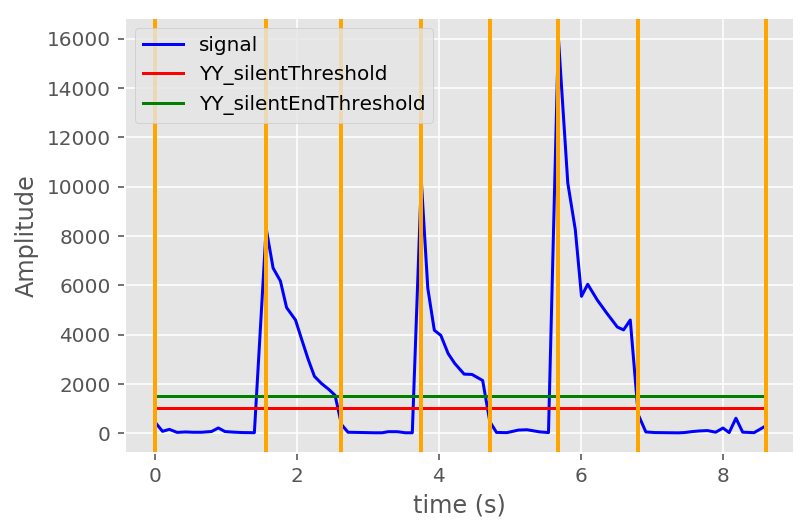

In [95]:
lSilenceTimestamps = getSilenceTimestamps(data, rate, show = 1)

### *NB: The fact that the find_peaks function is not super precise is actually a good point here as it allows to begin trimming our audio a bit after the "attack", which will give a cleaner Fourier Transform.* 😃

## Part 4: Getting the played notes in several trimmed audioSegments

*NB: The getIdxFromList function is not used in the final function.*

In [42]:
def getPlayingTimestamps(lSilenceTimestamps):
    ''' (!!) Hypothesis: The user isn't playing when clicking on the "record" button.
    Return lPlayingTimestamps which has the same formatting as lSilenceTimestamps.'''
    lPlayingTimestamps = []
    for idx, tuple_timestamps in enumerate(lSilenceTimestamps[:-1]):
        lPlayingTimestamps.append((tuple_timestamps[1], lSilenceTimestamps[idx + 1][0]))
    return lPlayingTimestamps

In [43]:
lPlayingTimestamps = getPlayingTimestamps(lSilenceTimestamps)

In [44]:
lPlayingTimestamps

[(1.5662853026779773, 2.6278753991002),
 (3.7536153242728174, 4.71967228936757),
 (5.685774606055642, 6.811582558618239)]

In [45]:
t_vec_list = t_vec.tolist()

In [46]:
def getIdxFromList(t_vec_list, lPlayingTimestamps):
    lIdx = []
    for timestamp_tuple in lPlayingTimestamps:
        t_start = t_vec_list.index(timestamp_tuple[0])
        t_end = t_vec_list.index(timestamp_tuple[1])
        lIdx.append((t_start,t_end))
    return lIdx

In [49]:
def exportTrimmedNotesAsWav(fileName, filePath, rate, YY_amplitude, lPlayingTimestamps):
    '''Also returns a list of the trimmed audio file paths.'''
    print("Number of notes = ", len(lPlayingTimestamps))
    print("\n")
    
    lTrimmedPaths = []
    
    for idx,tuple_timestamp in enumerate(lPlayingTimestamps):
        t_start, t_end = tuple_timestamp
        
        # Warning: One need to convert s to ms
        t_start *= 1000
        t_end *= 1000
        duration = t_end - t_start
        
        # Trimming audio
        padding = AudioSegment.silent(duration=duration)
        segment = AudioSegment.from_wav(filePath)[t_start:t_end] # from s to ms!!
        segment = padding.overlay(segment)
        
        # Set frame rate
        segment = segment.set_frame_rate(rate)
        
        # Export as wav
        exportFileName = "data/temp/trimmed/"+fileName[:-4]+"_"+str(idx)+'.wav'
        lTrimmedPaths.append(exportFileName)
        segment.export(exportFileName, format='wav')
        
    return lTrimmedPaths

In [51]:
YY_amplitude = data[:,1]

In [52]:
lTrimmedPaths = exportTrimmedNotesAsWav(fileName, filePath, rate, YY_amplitude, lPlayingTimestamps)

Number of notes =  3




In [53]:
lTrimmedPaths

['data/temp/trimmed/do0_0.wav',
 'data/temp/trimmed/do0_1.wav',
 'data/temp/trimmed/do0_2.wav']

In [54]:
os.getcwd()

'/Users/Tony/Desktop/projet-semaine-2'

In [55]:
fileName = "doremi.wav"

In [56]:
filePath = "data/temp/" + fileName

In [57]:
filePath

'data/temp/doremi.wav'

In [58]:
from math import log2, pow

def pitch(freq):
    A4 = 440
    C0 = A4*pow(2, -4.75)
    #name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    name = ["Do", "Do#", "Re", "Re#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"]
    
    h = round(12*log2(freq/C0))
    octave = h // 12
    n = h % 12
    return name[n] + str(octave)

In [83]:
def getFundamentalAndPlot(idx, subploatShape, filePath):
    '''Prepare to plot the subploats wrt time / FT of the idx-nth note.'''
    
    ## Retrieving useful data
    
    rate, data = wav.read(filePath)
    
    # Get sampling information
    Fs = rate # sample rate
    T = 1/Fs # sampling period
    t = np.shape(data)[0] / rate # seconds of sampling
    N = Fs*t # total points in signal
    
    # fourier transform and frequency domain
    Y_k = np.fft.fft(data[:,1])[0:int(N/2)]/N # FFT function from numpy
    Y_k[1:] = 2*Y_k[1:] # need to take the single-sided spectrum only
    Pxx = np.abs(Y_k) # be sure to get rid of imaginary part
    f = (1/N) * Fs * np.arange((int(N/2))); # frequency vector

    t_vec = np.linspace(0,t,N) # time vector for plotting
    
    
    ## Plotting wrt time:
    plt.subplot(int(subploatShape + str(2*idx + 1)))
    
    plt.xlabel('time (s)')
    plt.ylabel('Amplitude')
    plt.title('Note #' + str(idx + 1))
    plt.plot(t_vec,data[:,1])
    
    ## Getting fundamental frequency
    freq_fundamental = f[Pxx.argmax()]
    
    ## Plotting FT:
    plt.subplot(int(subploatShape + str(2*idx + 2)))
    
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.title(pitch(freq_fundamental))
    plt.xlim((20,5000)) #to change if needed
    
    plt.plot(f,Pxx,linewidth=2)
    
    return freq_fundamental

In [86]:
def processTrimmedNotes(lTrimmedPaths):
    n = len(lTrimmedPaths) # number of detected notes
    lFreq = []
    
    # We want a subploat with str(n) lines and 2 columns.
    subploatShape = str(n) + '2'
    print('subploatShape = ', subploatShape)
    
    fig = plt.figure()
    
    for idx, filePath in enumerate(lTrimmedPaths):
        lFreq.append(getFundamentalAndPlot(idx, subploatShape, filePath))
    
    fig.set_size_inches(15, 6 * n)
    plt.savefig('processed_figure.png', dpi=200)
    plt.show()
    return lFreq

subploatShape =  32


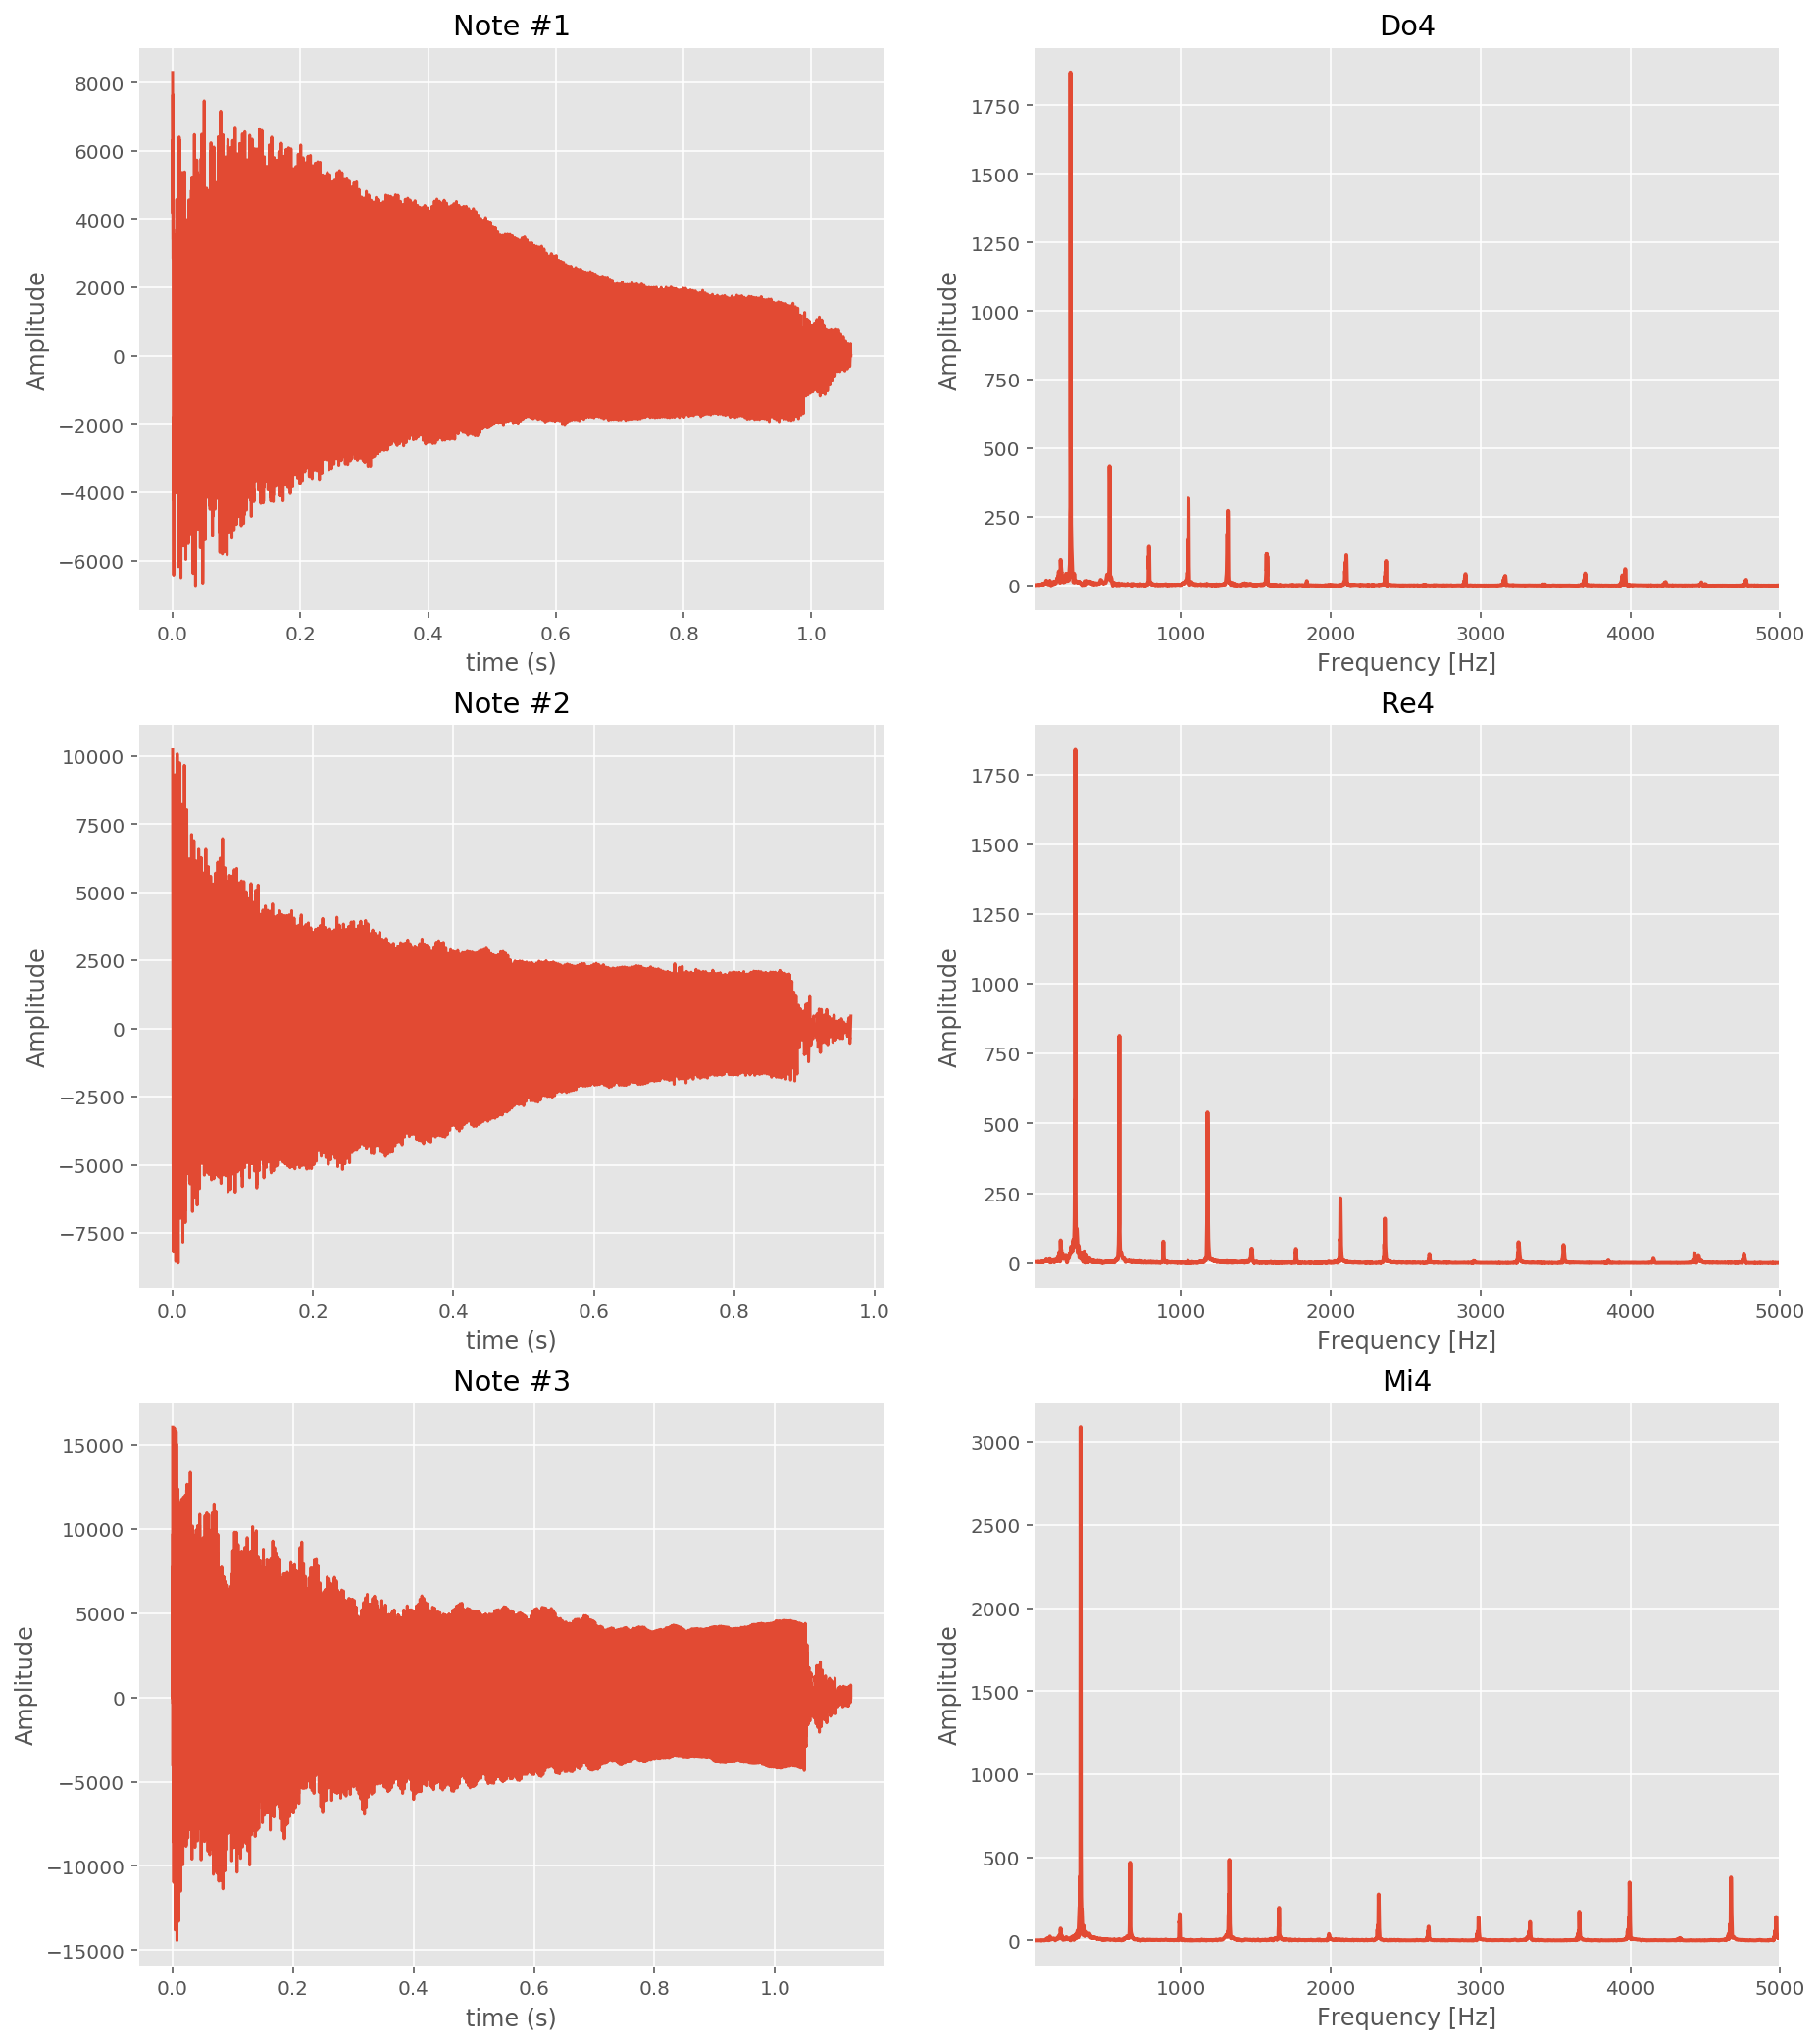

In [87]:
lFreq = processTrimmedNotes(lTrimmedPaths)

In [62]:
lFreq

[262.71298629201004, 295.03521126760563, 330.3769937167714]

In [63]:
lNotes = [pitch(freq) for freq in lFreq]

In [64]:
lNotes

['Do4', 'Re4', 'Mi4']